In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df=pd.read_csv("../data/dairy_cows.csv")
df.head() 

,ID,Species,Animal_Class,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,Welfare_Indicator,Indicator_Ease,Indicator_Resources
0,1,Dairy cows,Tie stalls,Pasture access,Gastro-enteric disorders,High,Moderate,Abdominal discomfort,Moderate,Low
1,1,Dairy cows,Cubicles,Pasture access,Gastro-enteric disorders,High,Moderate,Abdominal discomfort,Moderate,Low
2,2,Dairy cows,Tie stalls,Continuous housing for long periods,General disruption of behaviour,Low,Difficult,Agonistic behaviour,Moderate,Low
3,2,Dairy cows,Cubicles,Continuous housing for long periods,General disruption of behaviour,Low,Difficult,Agonistic behaviour,Moderate,Low
4,3,Dairy cows,Tie stalls,Insufficient space,Restriction of movement,High,Moderate,Agonistic interactions,Moderate,Medium


In [4]:
hazard_map = {
    # Feeding/Nutrition related hazards:
    'Underfeeding': 'H_FN', 'Poor pasture quality': 'H_FN', 'Poor quality feed (low nutritive value)': 'H_FN',
    'Poor quality feed (pathogens/toxins)': 'H_FN', 'Too few feeding places ': 'H_FN', 'Too few feeding places indoors': 'H_FN',
    'Insufficient access to water (broken system, poor management)': 'H_FN',
    'Insufficient access to water (inappropriate system design)': 'H_FN',

    # Housing/Environment related hazards:
    'Insufficient space': 'H_HE', 'Poor cubicle design': 'H_HE', 'Poor stall design / stall too small': 'H_HE',
    'Inadequate bedding (cubicle/stall floor)': 'H_HE', 'Fewer cubicles than cows': 'H_HE',
    'Inadequate flooring in passageways, feeding and milking areas': 'H_HE',
    'Continuous housing for long periods': 'H_HE', 'Inadequate maintenance of housing': 'H_HE',
    'Insufficient protection from weather': 'H_HE', 'Excessive noise (constant or sudden)': 'H_HE',
    'Lack of environmental enrichment': 'H_HE', 'Inadequate design of waiting area (size, flooring, crowding gates)': 'H_HE',
    'Being tied up temporarily': 'H_HE', 'Being tied without exercise for long periods ': 'H_HE',
    'Use of cow trainers': 'H_HE', 'Inadequate milking parlour design': 'H_HE',
    'Inadequate milking robot design': 'H_HE', 'Lack of space for exercise and social interactions': 'H_HE',
    'Poor calving conditions (pen design)': 'H_HE', 'Poor calving conditions (absence of pen)': 'H_HE',
    'Poor stall design / stall too small': 'H_HE', 'Inadequate housing design': 'H_HE',

    # Management/Husbandry:
    'Early separation of cow and calf': 'H_MH', 'Early separation of cow and calf (after 24h)': 'H_MH',
    'Mixing animals from different groups ': 'H_MH', 'Lack of facilities for sick animals': 'H_MH',
    'Milking robot breakdown': 'H_MH', 'Milking robot not used by cow': 'H_MH',
    'Inadequate milking equipment': 'H_MH', 'Lack of handling/restraining facilities': 'H_MH',
    'Too few feeding places indoors': 'H_FN',  # Already put above
    'Poor calving conditions (calving management)': 'H_MH', 'Delayed calving intervention': 'H_MH',
    'Difficulty calving because of the sire': 'H_MH',
    'Pasture access': 'H_MH' # You may need to adjust these mappings as you see fit
}

# If a hazard doesn't appear in the mapping, assign a default:
def map_hazard(h):
    return hazard_map.get(h, 'H_MH')  # default to H_MH if not found

df['Hazard_Category'] = df['Welfare_Hazards_Animal'].apply(map_hazard)

# Consequence Categories (broad example):
consequence_map = {
    # Health/Disease
    'Mastitis': 'C_HD', 'Locomotor disorders (including lameness)': 'C_HD', 'Metabolic disorders': 'C_HD',
    'Soft tissue lesions and integument damage': 'C_HD', 'Skin disorders (other than soft tissue lesions and integument damage)': 'C_HD',
    'Bone lesions (incl. fractures and dislocations)': 'C_HD', 'Gastro-enteric disorders': 'C_HD', 'Reproductive disorders': 'C_HD',
    'Teat disorders': 'C_HD',

    # Behavioral/Welfare
    'General disruption of behaviour': 'C_BW', 'Inability to perform comfort behaviour': 'C_BW',
    'Restriction of movement': 'C_BW', 'Resting problems': 'C_BW', 'Impaired maintenance behaviour': 'C_BW',
    'Impaired social behaviour': 'C_BW', 'Prolonged hunger': 'C_BW', 'Inability to chew and/or ruminate': 'C_BW',
    'Time budgets (disruption of behaviour)': 'C_BW', 'Time budgets (lack of rest)': 'C_BW', 
    'Time budgets (prevention of behaviour)': 'C_BW', 'Time budgets (reduced behavioural repertoire)': 'C_BW',
    'Frequency of lying bouts': 'C_BW', 'Duration of lying down movement': 'C_BW',
    'Deviation from normal, uninterrupted getting up movement': 'C_BW', 'Injuries': 'C_HD', # injuries treated as health/disease

    # Stress-Related
    'Separation stress': 'C_SR', 'Environmental stress': 'C_SR', 'Group (social) stress': 'C_SR',
    'Handling stress': 'C_SR', 'Heat stress': 'C_SR', 'Cold stress': 'C_SR', 'Isolation stress': 'C_SR',

    # Nutritional/Growth - (Prolonged hunger is above in behavioral/welfare, but you might separate if desired)
    # If you want to separate Prolonged hunger into nutritional category, you can create a new category C_NG. For now, left as is.

    # Mortality
    'Mortality': 'C_M'
}

def map_consequence(c):
    return consequence_map.get(c, 'C_BW')  # default to behavioral/welfare if not found

df['Consequence_Category'] = df['Welfare_Hazards_Consequences'].apply(map_consequence)

# Indicator Categories (example):
indicator_map = {
    # Health/Physiological indicators:
    'Milk somatic cell count (bulk or individual)': 'I_HP', 'Hot, red, painful udder': 'I_HP',
    'Distended udder': 'I_HP', 'Metabolic disorders': 'I_HP', 'Hock alterations': 'I_HP', 'Knee alterations': 'I_HP',
    'Lesions of the claw': 'I_HP', 'Neck injuries': 'I_HP', 'Teat disorders': 'I_HP', 'Disease': 'I_HP',
    'Body condition scoring': 'I_HP',

    # Behavioral/Welfare:
    'Abdominal discomfort': 'I_BW', 'Agonistic behaviour': 'I_BW', 'Agonistic interactions': 'I_BW',
    'Allo-grooming': 'I_BW', 'Altered resting posture': 'I_BW', 'Amount of eye white': 'I_BW',
    'Brush use': 'I_BW', 'Calving behaviour (difficult/long calving)': 'I_BW',
    'Calving records (death of cow)': 'I_BW', 'Calving records (difficulty calving)': 'I_BW',
    'Calving records (duration of calving)': 'I_BW', 'Coat condiition / cleanliness': 'I_BW',
    'Cow Pain Scale (attention towards surroundings, head position, ear position, facial expression, response to approach, back position, lameness)': 'I_BW',
    'Deviation from normal, uninterrupted getting up movement': 'I_BW', 'Duration of lying down movement': 'I_BW',
    'Frequency of lying bouts': 'I_BW', 'Gait assessment': 'I_BW', 'Huddling': 'I_BW',
    'Impaired calving behavour': 'I_BW', 'Impaired maintenance behaviour': 'I_BW', 'Impaired social behaviour': 'I_BW',
    'Increased standing': 'I_BW', 'Injuries': 'I_BW', 'Lying behaviour synchronisation': 'I_BW',
    'Lying time': 'I_BW', 'Metabolic disorders': 'I_HP', # If repeated, leave first relevant category or handle carefully
    'Physiological stress indicators': 'I_HP', 'Respiratory rate and panting ': 'I_HP',
    'Self-grooming': 'I_BW', 'Shivering': 'I_BW', 'Speed': 'I_BW', 'Step activity': 'I_BW',
    'Sunburn injury': 'I_BW', 'Time budgets (disruption of behaviour)': 'I_BW',
    'Time budgets (increased standing, decreased lying)': 'I_BW', 'Time budgets (lack of rest)': 'I_BW',
    'Time budgets (prevention of behaviour)': 'I_BW', 'Time budgets (reduced behavioural repertoire)': 'I_BW',
    'Time spent looking out of pen': 'I_BW', 'Vocalisations  ': 'I_BW', 'Walking distance': 'I_BW',
    'Weight loss (adults) or restricted weight gain (calves)': 'I_BW'
}

def map_indicator(i):
    return indicator_map.get(i, 'I_BW')  # default to I_BW if not found

df['Indicator_Category'] = df['Welfare_Indicator'].apply(map_indicator)


In [5]:
df

,ID,Species,Animal_Class,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,Welfare_Indicator,Indicator_Ease,Indicator_Resources,Hazard_Category,Consequence_Category,Indicator_Category
0,1,Dairy cows,Tie stalls,Pasture access,Gastro-enteric disorders,High,Moderate,Abdominal discomfort,Moderate,Low,H_MH,C_HD,I_BW
1,1,Dairy cows,Cubicles,Pasture access,Gastro-enteric disorders,High,Moderate,Abdominal discomfort,Moderate,Low,H_MH,C_HD,I_BW
2,2,Dairy cows,Tie stalls,Continuous housing for long periods,General disruption of behaviour,Low,Difficult,Agonistic behaviour,Moderate,Low,H_HE,C_BW,I_BW
3,2,Dairy cows,Cubicles,Continuous housing for long periods,General disruption of behaviour,Low,Difficult,Agonistic behaviour,Moderate,Low,H_HE,C_BW,I_BW
4,3,Dairy cows,Tie stalls,Insufficient space,Restriction of movement,High,Moderate,Agonistic interactions,Moderate,Medium,H_HE,C_BW,I_BW
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,192,Dairy cows,Tie stalls,Early separation of cow and calf (after 24h),Separation stress,High,Easy,Vocalisations,Moderate,Medium,H_MH,C_SR,I_BW
384,193,Dairy cows,Cubicles,Insufficient space,Restriction of movement,High,Moderate,Walking distance,Difficult,High,H_HE,C_BW,I_BW
385,193,Dairy cows,Tie stalls,Insufficient space,Restriction of movement,High,Moderate,Walking distance,Difficult,High,H_HE,C_BW,I_BW
386,194,Dairy cows,Cubicles,Pasture access,Gastro-enteric disorders,High,Moderate,Weight loss (adults) or restricted weight gain...,Easy,Low,H_MH,C_HD,I_BW


In [6]:
# Checking the one-hot encoding result
encoded_columns = [
    'Hazard_H_FN', 'Hazard_H_HE', 'Hazard_H_MH', 
    'Consequence_C_HD', 'Consequence_C_BW', 'Consequence_C_SR', 'Consequence_C_M',
    'Indicator_I_HP', 'Indicator_I_BW'
]

# Confirming the presence of the expected encoded columns
missing_columns = [col for col in encoded_columns if col not in df.columns]

# If any columns are missing, print them; otherwise, proceed with the PCA
if missing_columns:
    print(f"Missing columns after one-hot encoding: {missing_columns}")
else:
    # Reperform PCA including the expected one-hot encoded columns
    columns_for_pca = ['Welfare_Hazards_Impact', 'Ease_of_Hazard_Mitigation', 'Indicator_Ease', 
                       'Indicator_Resources'] + encoded_columns
    df_scaled = scaler.fit_transform(df[columns_for_pca])

    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(df_scaled)

    # Create a new DataFrame for the PCA results
    pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))])

    # Plot the explained variance
    explained_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.title('Explained Variance by Principal Components (with Correct One-Hot Encoding)')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Variance Explained')
    plt.show()

    # Display the updated PCA DataFrame to the user
    tools.display_dataframe_to_user(name="Correct PCA Results with One-Hot Encoded Variables", dataframe=pca_df)


Missing columns after one-hot encoding: ['Hazard_H_FN', 'Hazard_H_HE', 'Hazard_H_MH', 'Consequence_C_HD', 'Consequence_C_BW', 'Consequence_C_SR', 'Consequence_C_M', 'Indicator_I_HP', 'Indicator_I_BW']


In [17]:
X

,Hazard_Category,Consequence_Category,Indicator_Category,Welfare_Hazards_Impact_Num,Ease_of_Hazard_Mitigation_Num,Indicator_Ease_Num,Indicator_Resources_Num,Animal_Class_Num
0,2,1,0,2,2,2,1,0
1,2,1,0,2,2,2,1,1
2,1,0,0,1,3,2,1,0
3,1,0,0,1,3,2,1,1
4,1,0,0,2,2,2,2,0
...,...,...,...,...,...,...,...,...
383,2,3,0,2,1,2,2,0
384,1,0,0,2,2,3,3,1
385,1,0,0,2,2,3,3,0
386,2,1,0,2,2,1,1,1


In [9]:
#-----------------------------
# 4. Standardize and Run PCA
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get explained variance
explained_variance = pca.explained_variance_ratio_
components = pca.components_

print("Explained variance ratio:", explained_variance)
print("Principal Components:\n", components)


Explained variance ratio: [0.34334241 0.1530946 ]
Principal Components:
 [[-0.12035638  0.38410097  0.30561572 -0.41913926 -0.01528123  0.54703189
   0.51887603  0.01386923]
 [ 0.70540317  0.46485222  0.09035511  0.11783332 -0.48544427 -0.08395044
  -0.06073903 -0.13370489]]


In [10]:
loadings = pd.DataFrame(components, columns=features, index=['PC1', 'PC2'])
print("\nLoadings (Principal Component loadings):")
print(loadings)



Loadings (Principal Component loadings):
     Hazard_Category  Consequence_Category  Indicator_Category  \
PC1        -0.120356              0.384101            0.305616   
PC2         0.705403              0.464852            0.090355   

     Welfare_Hazards_Impact_Num  Ease_of_Hazard_Mitigation_Num  \
PC1                   -0.419139                      -0.015281   
PC2                    0.117833                      -0.485444   

     Indicator_Ease_Num  Indicator_Resources_Num  Animal_Class_Num  
PC1            0.547032                 0.518876          0.013869  
PC2           -0.083950                -0.060739         -0.133705  


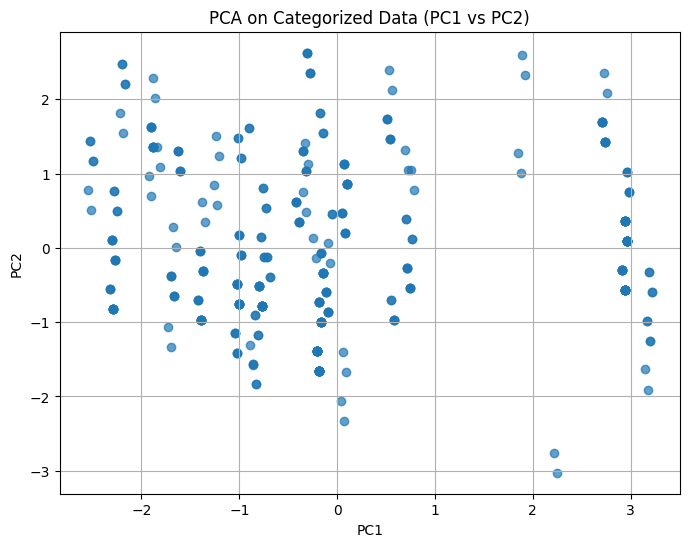

In [11]:
# -----------------------------
# 6. Plot the Results
# -----------------------------
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.7)
plt.title("PCA on Categorized Data (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

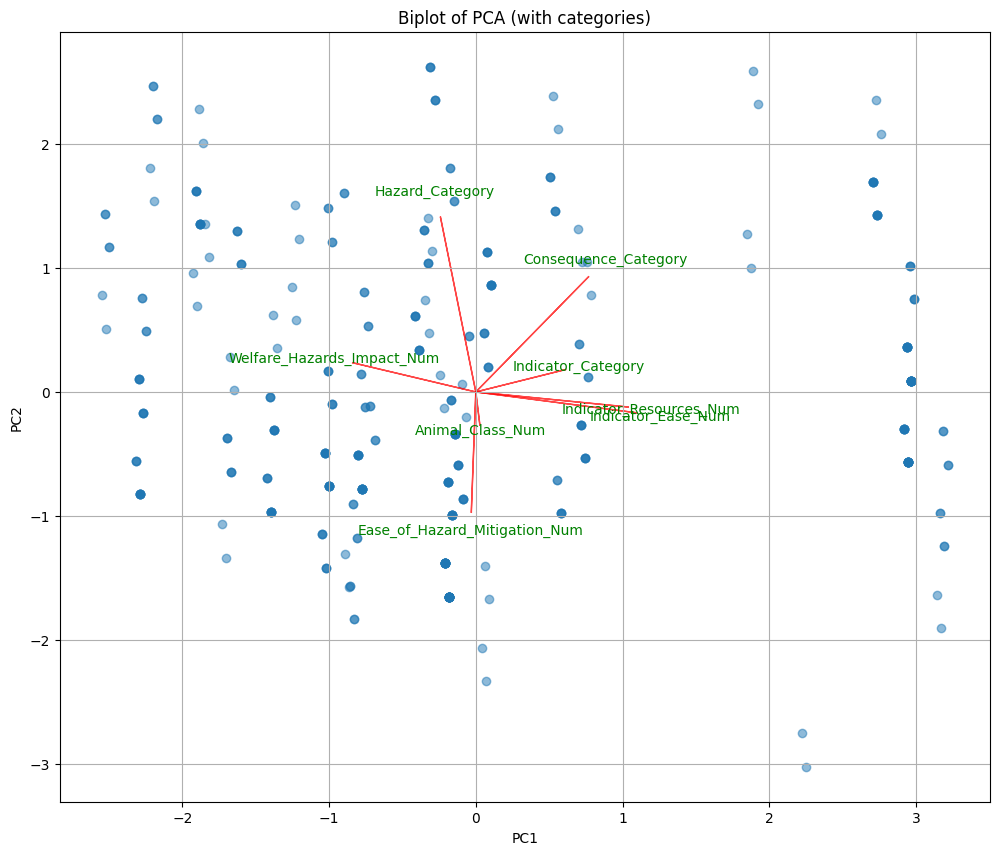

In [12]:
def biplot(score, coeff, labels=features):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[1]
    plt.scatter(xs, ys, alpha=0.5)
    for i in range(n):
        plt.arrow(0, 0, coeff[0,i]*2, coeff[1,i]*2, color='r', alpha=0.7)
        plt.text(coeff[0,i]*2*1.15, coeff[1,i]*2*1.15, labels[i], color='g', ha='center', va='center')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)

plt.figure(figsize=(12,10))
biplot(X_pca, pca.components_)
plt.title("Biplot of PCA (with categories)")
plt.show()

# Interpretation

## Loadings PC1, PC2


| Variable | PC1 | PC2 |
|----------|-----|-----|
| Hazard_Category | -0.120356 | 0.705403 |
| Consequence_Category | 0.384101 | 0.464852 |
| Indicator_Category | 0.305616 | 0.090355 |
| Welfare_Hazards_Impact_Num | -0.419139 | 0.117833 |
| Ease_of_Hazard_Mitigation_Num | -0.015281 | -0.485444 |
| Indicator_Ease_Num | 0.547032 | -0.083950 |
| Indicator_Resources_Num | 0.518876 | -0.060739 |
| Animal_Class_Num | 0.013869 | -0.133705 |

### PC1 interpretation

| Variable | PC1 | Absolute Value |
|----------|-----|----------------|
| Indicator_Ease_Num | 0.547032 | 0.547032 |
| Indicator_Resources_Num | 0.518876 | 0.518876 |
| Consequence_Category | 0.384101 | 0.384101 |
| Welfare_Hazards_Impact_Num | -0.419139 | 0.419139 |
| Hazard_Category | -0.120356 | 0.120356 |
| Indicator_Category | 0.305616 | 0.305616 |
| Ease_of_Hazard_Mitigation_Num | -0.015281 | 0.015281 |
| Animal_Class_Num | 0.013869 | 0.013869 |

- **Positively loaded:** Indicator_Ease_Num and Indicator_Resources_Num
- **Negatively loaded:** Welfare_Hazards_Impact_Num

This suggests that PC1 differentiates observations based on a contrast between hazard impact and indicator-related attributes:
Observations are associated with more difficult indicators (higher Indicator_Ease_Num) and higher resource requirements (Indicator_Resources_Num). These also tend to differ in the nature of consequences (Consequence_Category) and indicators chosen (Indicator_Category), suggesting a cluster of scenarios where indicators are more resource-intensive and harder to implement.